# B3/4
In this part we try to train an agent to play the atari games

# To load model, run cells until told stop and continue to end

In [23]:
import sys
import os
import math
import pdb
import time
import random
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from skimage.color import rgb2gray
from skimage.transform import resize

Pre porcess the data so that the image is resized to 28 by 28 image 

In [24]:
def preprocess(observation):
    resized = resize(observation, (28, 28), preserve_range=True)
    return rgb2gray(resized).astype("uint8")

Need to get the first state of the environmnet. Since we feed in four stacked images at a time, for the initial state of a game we do it here

In [25]:
def get_state(env):
    state_list = []
    observation = env.reset()
    for _ in range(4):
        state_list.append(preprocess(observation))
        action = env.action_space.sample()
        observation, _, _, info = env.step(action)
    state = np.stack(state_list, axis=2)
    return env, state, observation

Need to update the state so that the oldest frame is forgotten and the newest frame is added to the stack

In [26]:
def update_state(state, observation):
    state = np.append(state, preprocess(observation).reshape(28, 28, 1), axis=2)
    new_state = state[:, :, 1:]
    return new_state

Clip rewards as done asked for

In [27]:
def clip_rewards(reward):
    if reward > 0:
        return 1
    elif reward < 0:
        return -1
    else:
        return 0

In [28]:
def ep_grred(action_value, epsilon, env):
    if random.uniform(0, 1) <= epsilon:
        return env.action_space.sample()  # random action
    else:
        return np.argmax(action_value)  # best action

In [29]:
def conv_layer(x, W, b, stride=2):
    con = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')
    con = tf.nn.relu(tf.nn.bias_add(con,b))
    return con

Main Q network, pass through the conv layers to a fully connected layer, calulate the loss when the td target is passed back in and optimize

In [30]:
def Q_net(state, action, td_target, n_act, alpha=0.001):
    weights = {
        'conv1': tf.Variable(tf.truncated_normal([6, 6, 4, 16], 0, 0.01)),
        'conv2': tf.Variable(tf.truncated_normal([4, 4, 16, 32], 0, 0.01)),
        'hidden': tf.Variable(tf.truncated_normal([7*7*32, 256], 0, 0.01)),
        'output': tf.Variable(tf.truncated_normal([256, n_act], 0, 0.01))
    }
    
    
    
    biases = {
        'conv1': tf.Variable(tf.constant(0.1, shape=[16])),
        'conv2': tf.Variable(tf.constant(0.1, shape=[32])),
        'hidden': tf.Variable(tf.constant(0.1, shape=[256])),
        'output': tf.Variable(tf.constant(0.1, shape=[n_act]))
    }

    # Conv layers
    conv1 = conv_layer(state, weights['conv1'], biases['conv1'], stride=2)
    
    conv2 = conv_layer(conv1, weights['conv2'], biases['conv2'], stride=2)
    
    conv2_flat = tf.reshape(conv2,  [-1, 7*7*32])

    
    #fully connected
    fc = tf.nn.relu(tf.matmul(conv2_flat, weights['hidden']) + biases['hidden'])
    
    q = tf.matmul(fc, weights['output']) + biases['output']

    
    #loss
    qa = tf.reshape(tf.gather_nd(q, action), [-1, 1])
    
    loss = tf.reduce_mean(tf.square(td_target - qa)/2)
    
    opt = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)
    return opt, q, loss

Same as above with different weights that are to be coppied evry 5000 steps

In [31]:
def target_Q(state, reward, is_terminal, n_act, gamma=0.99):
    weights_target = {
        'conv1': tf.Variable(tf.truncated_normal([6, 6, 4, 16], 0, 0.01)),
        'conv2': tf.Variable(tf.truncated_normal([4, 4, 16, 32], 0, 0.01)),
        'hidden': tf.Variable(tf.truncated_normal([7*7*32, 256], 0, 0.01)),
        'output': tf.Variable(tf.truncated_normal([256, n_act], 0, 0.01))
    }
    biases_target = {
        'conv1': tf.Variable(tf.constant(0.1, shape=[16])),
        'conv2': tf.Variable(tf.constant(0.1, shape=[32])),
        'hidden': tf.Variable(tf.constant(0.1, shape=[256])),
        'output': tf.Variable(tf.constant(0.1, shape=[n_act]))
    }

    # Convolutional layers
    conv1 = conv_layer(state, weights_target['conv1'], biases_target['conv1'], stride=2)
    
    conv2 = conv_layer(conv1, weights_target['conv2'], biases_target['conv2'], stride=2)
    
    conv2_flat = tf.reshape(conv2,  [-1, 7*7*32])

    # Fully connected layers
    
    fc = tf.nn.relu(tf.matmul(conv2_flat, weights_target['hidden']) + biases_target['hidden'])
    
    q_prime = tf.matmul(fc, weights_target['output']) + biases_target['output']

    
    q_prime_max = tf.reshape(tf.reduce_max(q_prime, reduction_indices=[1]), [-1, 1])
    
    target = reward + gamma * tf.multiply(is_terminal, q_prime_max)
    return target


Copy the current vars to the target variables

In [32]:
def copy_vars_to_target(tf_vars, sess):
    n_var = int(len(tf_vars)/2) 
    op_list = []
    for idx, var in enumerate(tf_vars[0:n_var]):
        op_list.append(tf_vars[idx+n_var].assign(var.value()))
    for op in op_list:
        sess.run(op)

In [33]:
class exp_replay(object):
    def __init__(self, batch_size, max_buffer_size):
        self.min_size = batch_size
        self.max_size = max_buffer_size
        self.buffer = []

    def replay_update(self, s, a, r, s_prime, terminal):
        if len(self.buffer) >= self.max_size:
            self.buffer = self.buffer[1:]
        self.buffer.append((s, a, r, s_prime, terminal))

    def buff_large(self):
        if len(self.buffer) > self.min_size:
            return True
        return False

    def samp_buff(self, state, action, reward, is_terminal):
        sample = np.reshape(np.array(random.sample(self.buffer, self.min_size)), [self.min_size, 5])
        act = sample[:,1].reshape(-1, 1)
        act = np.append(np.arange(len(act)).reshape(-1, 1), act, axis=1)

        sample_dict_opt = {
            state: np.stack(sample[:,0], axis=0),
            action: act
        }

        sample_dict_target = {
            state: np.stack(sample[:,3], axis=0),
            reward: np.stack(sample[:,2], axis=0).reshape(-1, 1), 
            is_terminal: np.stack(sample[:,4], axis=0).reshape(-1, 1)
        }
        return sample_dict_opt, sample_dict_target

In [34]:
def init_tf_vars(n_act):
    """Initialize tensorflow variables"""
    state = tf.placeholder("float", [None,28, 28, 4])
    action = tf.placeholder(tf.int32, [None, 2])
    td_target = tf.placeholder("float", [None, 1])
    reward = tf.placeholder("float", [None, 1])
    is_terminal = tf.placeholder("float", [None, 1])
    return state, action, td_target, reward, is_terminal

# DO NOT RUN CELLS UNTIL LOAD CELL BELOW UNTIL LOAD CELL

In [12]:
#  parameters
max_steps = 1000000
t_freq = 50000  # test every t_freq steps
test_episodes = 100
max_eps_length = 10000000
gamma = 0.99
max_buffer_size = 200000
batch_size = 32
alpha = 0.001
up_freq = 5000  # copy weights
epsilon = 0.01


# Variables to store results/counts
mean_FCL= []
mean_SL = []
mean_opp_list= []
loss_list=[]
mean_cum_rewards = []
counts_so_far = 0
game = 'MsPacman-v3'
name = 'Boxing'

In [14]:

# train and test env
env = gym.make(game)  
test_env = gym.make(game)  
n_act = env.action_space.n

state, action, td_target, reward, is_terminal = init_tf_vars(n_act)
target = target_Q(state, reward, is_terminal, n_act, gamma=gamma)
opt, q, loss = Q_net(state, action, td_target, n_act, alpha=alpha)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
relpay_buff = exp_replay(batch_size, max_buffer_size)  # initialize buffer
start = time.time()


In [ ]:
#Run the training

with tf.Session() as sess:
    sess.run(init)

    while counts_so_far <= max_steps: # run for 1000000 steps
        env, s, obs = get_state(env)  # get initial state (4 frames), this also calls env.reset
        end = False

        #Run a single episode and perform Q update
        for t in range(max_eps_length):
            counts_so_far += 1

            
            q_now = sess.run(q, feed_dict={state: s.reshape(-1, 28, 28, 4)})
            a = ep_grred(q_now, epsilon, env)
            next_obs, r, done, info = env.step(a)
            r = clip_rewards(r)

            s_prime = update_state(s, obs)
            if done:
                terminal = 0
                end = True
            else:
                terminal = 1

            # Update buffer and perform mini-batch Q update
            relpay_buff.replay_update(s, a, r, s_prime, terminal)
            if relpay_buff.buff_large():
                
                
                this_dict, targ_dict = relpay_buff.samp_buff(state, action, reward, is_terminal)
                
                targ = sess.run(target, feed_dict=targ_dict)
                
                this_dict[td_target] = targ
                _, l = sess.run([opt, loss], feed_dict=this_dict)
                
                loss_list.append(l)

            # copy current network parameters
            if counts_so_far % up_freq == 0:
                print("\n#------- copy parameters at step {}".format(counts_so_far))
                print("#------- Total time elapsed = %s\n" % str(time.time()-start))
                
                training_variables = tf.trainable_variables() 
                copy_vars_to_target(training_variables, sess)
                saver.save(sess, './new_models/PartB/'+name+'/B3'+game)

            # Evaluate on 100 episodes every 50,000 steps 
            if counts_so_far % t_freq == 0:
                score_list, op_s_list, frame_count_list, cum_rewards_list = [], [], [], []

                print("\n# Running %d episodes for testing for step %d" % (test_episodes, counts_so_far))
                print("#------- Total time elapsed = %s\n" % str(time.time()-start))
                for episode in range(test_episodes):
                    print('running epsisode:{}'.format(episode+1))
                    
                    score = op_s = frame_count = cum_reward = 0
                    
                    test_env, s_test, test_obs = get_state(test_env)
                    # loop t
                    for test_t in range(max_eps_length):
                        
                        q_now = sess.run(q, feed_dict={state: s_test.reshape(1, 28, 28, 4)})
                        a = np.argmax(q_now)
                        next_state_t, r2, done, info = test_env.step(a)
                        cum_reward += clip_rewards(r2) * gamma**test_t

                        if r2 > 0:
                            score += r2
                        else:
                            op_s -= r2

                        s_prime_test = update_state(s_test, test_obs)

                        if done:
                            score_list.append(score)
                            op_s_list.append(op_s)
                            frame_count_list.append(test_t+1)
                            cum_rewards_list.append(cum_reward)
                            break
                        s_test = s_prime_test
                        test_obs = next_state_t

                ## Update results lists
                mean_SL.append(np.array(np.mean(score_list)))
                mean_opp_list.append(np.array(np.mean(op_s_list)))
                mean_FCL.append(np.array(np.mean(frame_count_list)))
                mean_cum_rewards.append(np.array(np.mean(cum_rewards_list)))

               

                print('saving model...')
                saver.save(sess, './new_models/PartB/'+name+'/B3'+game)
               
                np.save(filename, saved_results)
                filename = './results/B3loss_'+game+'.npy'
                np.save(filename, loss_list)

            if end:
                break
            s = s_prime
            obs = next_obs



In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Alex\Anaconda3\envs\Assignment_3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'datetime', 'get_state', 'resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Plot the loss over training

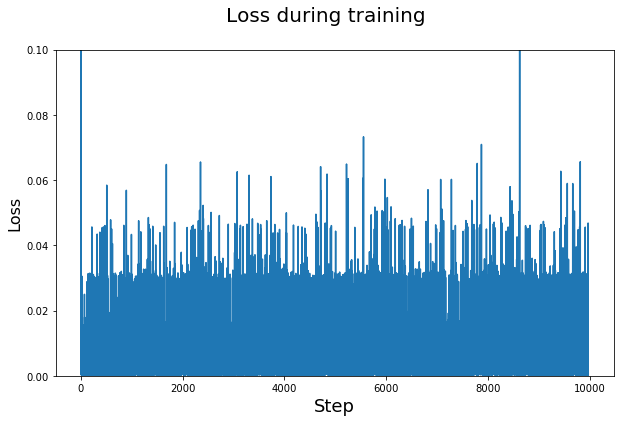

In [21]:
x_ax = np.linspace(0,len(loss_list),len(loss_list))
fig = plt.figure()
plt.plot(x_ax,loss_list) # plotting t,a separately
fig.suptitle('Loss during training', fontsize=20)
plt.xlabel('Step', fontsize=18)
plt.ylabel('Loss', fontsize=16)
plt.ylim(ymax = 0.1, ymin = 0)

plt.show()

fig.savefig('./results/B3_loss_'+game+'.jpg')

C:\Users\Alex\Anaconda3\envs\Assignment_3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


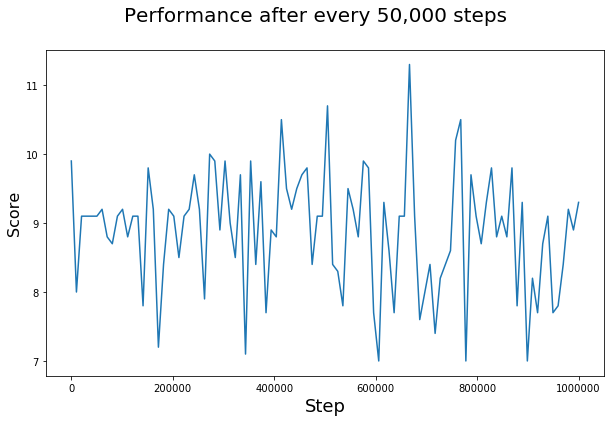

In [35]:
x_ax = np.linspace(0,1000000-1,len(mean_SL))
fig = plt.figure()
plt.plot(x_ax,mean_SL) # plotting t,a separately
fig.suptitle('Performance after every 50,000 steps', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Step', fontsize=18)
plt.ylabel('Score', fontsize=16)
#plt.ylim(ymax = 0.5, ymin = 0)
plt.show()
fig.savefig('./results/pics/B3_score_'+game+'.jpg')

## RUN FROM HERE

In [12]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [13]:
games = ['MsPacman-V3','Pong-V3','Boxing-V3']
for i in range(3):
    game =games[i]
    filename = './results/B3results_'+game+'.npy'
    restored_data = np.load(filename)
    
    print('The results for {} were:'.format(game))
    print("Mean score = %f, stdev score = %f,computer score %f, stddev %f,mean frame count %f, stddev %f, mean reward = %f, stdev r = %f\n" % totuple(restored_data))

The results for MsPacman-V3 were:
Mean score = 161.300000, stdev score = 41.464563,computer score 0.000000, stddev 0.000000,mean frame count 736.730000, stddev 83.748654, mean reward = 4.267406, stdev r = 0.750235

The results for Pong-V3 were:
Mean score = 0.200000, stdev score = 0.400000,computer score 21.000000, stddev 0.000000,mean frame count 1217.400000, stddev 476.334378, mean reward = -0.869525, stdev r = 0.535989

The results for Boxing-V3 were:
Mean score = 9.300000, stdev score = 3.100000,computer score 34.700000, stddev 9.241753,mean frame count 2368.500000, stddev 9.383496, mean reward = -0.259456, stdev r = 0.197055



# Load Model
To restore the model of each game, run the cell with the game file first then run the model below

## MsPacman

In [14]:
name = 'MsPacman'
game = 'MsPacman-v3'
file_name =  './new_models/B3'+game
save_MDir = './new_models/'
save_model = os.path.join(save_MDir,file_name)
init = tf.global_variables_initializer()
restore_file = './new_models/PartB/'+name+'/B3'+game
#restored_data = np.load(restore_file)
print(file_name)

./new_models/B3MsPacman-v3


## Boxing

In [27]:
name = 'Boxing'
game = 'Boxing-v3'
file_name =  './new_models/B3'+game
save_MDir = './new_models/'
save_model = os.path.join(save_MDir,file_name)
init = tf.global_variables_initializer()
restore_file = './new_models/PartB/'+name+'/B3'+game
#restored_data = np.load(restore_file)
print(file_name)

./new_models/B3Boxing-v3


## Pong

In [36]:
name = 'Pong'
game = 'Pong-v3'
file_name =  './new_models/B3'+game
save_MDir = './new_models/'
save_model = os.path.join(save_MDir,file_name)
init = tf.global_variables_initializer()
restore_file = './new_models/PartB/'+name+'/B3'+game
#restored_data = np.load(restore_file)
print(file_name)

./new_models/B3Pong-v3


## Test model for 100 episodes

In [ ]:
# test and train enviroments
tf.reset_default_graph()

env = gym.make(game)  
test_env = gym.make(game) 
n_act = env.action_space.n
gamma = 0.99
alpha = 0.001
test_episodes = 5
max_eps_length= 10000000
state, action, td_target, reward, is_terminal = init_tf_vars(n_act)
target = target_Q(state, reward, is_terminal, n_act, gamma=gamma)
opt, q, loss = Q_net(state, action, td_target, n_act, alpha=alpha)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

start = time.time()


with tf.Session() as sess:
    sess.run(init)
    
    start = time.time()
    score_list, op_s_list, frame_count_list, cum_rewards_list = [], [], [], []
    
    
    print("Running 100 test episodes")
    for episode in range(test_episodes):
        #
        
        print('running episode: {}'.format(episode+1))
        score = op_s = frame_count = cum_reward = 0
        

        test_env, s_test, test_obs = get_state(test_env)
        

        saver.restore(sess = sess, save_path= restore_file)
        for test_t in range(max_eps_length):
            q_now = sess.run(q, feed_dict={state: s_test.reshape(1, 28, 28, 4)})
            a = np.argmax(q_now)
            next_state_t, r2, done, info = test_env.step(a)
            cum_reward += clip_rewards(r2) * gamma**test_t

            if r2 > 0:
                score += r2
            else:
                op_s -= r2

            s_prime_test = update_state(s_test, test_obs)

            if done:
                score_list.append(score)
                op_s_list.append(op_s)
                frame_count_list.append(test_t+1)
                cum_rewards_list.append(cum_reward)
                break
            s_test = s_prime_test
            test_obs = next_state_t


    # Print results
    result_list = (np.mean(np.array(score_list)), np.std(np.array(score_list)), 
                     np.mean(np.array(frame_count_list)), np.std(np.array(frame_count_list)))
    print("\nMean score = %f, stdev score = %f, mean frame count = %f, stdev frame count = %f" % result_list)